# Condition Association Code Template

# Import Libraries

- The following libraries are needed for analysis. 
- When using the DatasetBuilder in All of Us, the libraries `tidyverse` and `bigrquery` will **automatically be imported** with the datasets.
- The libraries `table1` and `IRdisplay` will have to be **imported separately**.

In [1]:
library(tidyverse)
library(table1)
library(IRdisplay)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'table1'

The following objects are masked from 'package:base':

    units, units<-



# Import Data

- This data is meant to **mimic** the All of Us datasets.
- The real datasets will be **imported with SQL code** (2 coding cells per dataset).

In [2]:
set.seed(123)  # Setting seed for reproducibility

# Generating random data for case and control dfs
generate_random_data <- function(n) {
  data.frame(
    person_id = 1:n,
    sex_at_birth = sample(c("Male", "Female"), n, replace = TRUE),
    date_of_birth = format(as.POSIXct(runif(n, 
                                            as.numeric(as.POSIXct("1945-01-01 UTC")), 
                                            as.numeric(as.POSIXct("2002-12-31 UTC"))), 
                           origin="1970-01-01"), "%Y-%m-%d %H:%M:%S UTC"),
    race = sample(c("Black or African American", "White", "Asian"), n, replace = TRUE),
    ethnicity = sample(c("Hispanic or Latino", "Not Hispanic or Latino"), n, replace = TRUE),
    stringsAsFactors = FALSE
  )
}

dataset_12345678_person_df <- generate_random_data(300)
dataset_23456789_person_df <- generate_random_data(1000)

# Generate random df for condition

# Combined person IDs from df1 and df2
all_person_ids <- c(dataset_12345678_person_df$person_id, dataset_23456789_person_df$person_id)

# Randomly sample from the combined person IDs for a specified number of occurrences
# For this example, let's say we want 500 occurrences (you can adjust this number)
disease_occurrences <- sample(all_person_ids, 500, replace = TRUE)

# Create the dataframe
dataset_34567890_condition_df <- data.frame(person_id = disease_occurrences)

# Rename Dataframes

- **Rename the All of Us dataframes here.**
- In the database, the dataframe names look like `dataset_12345678_domain_df`

In [3]:
case_df <- dataset_12345678_person_df

control_df <- dataset_23456789_person_df

condition <- dataset_34567890_condition_df

- **Examine the data and its dimensions.**

In [4]:
head(case_df)
dim(case_df)

person_id,sex_at_birth,date_of_birth,race,ethnicity
1,Male,1990-07-03 16:34:24 UTC,White,Hispanic or Latino
2,Male,1945-07-19 18:05:52 UTC,Black or African American,Not Hispanic or Latino
3,Male,1990-03-08 22:38:28 UTC,Asian,Not Hispanic or Latino
4,Female,1987-04-21 17:06:06 UTC,Asian,Hispanic or Latino
5,Male,1981-07-19 02:37:22 UTC,Asian,Hispanic or Latino
6,Female,1972-11-22 02:41:58 UTC,White,Not Hispanic or Latino


[1] 300   5

# Flag the Outcome

- Since `case_df` and `control_df` were built on the inclusion/exclusion of a certain condition, we must **create a new column** to flag this condition.
- We will call it the `outcome` column and assign `1` or `0` to those with or without the condition, respectively.

In [5]:
# Assign all cases with the value 1 in a new column called 'outcome'.
case_df$outcome <- 1

# Assign all controls with the value 0 to same column.
control_df$outcome <- 0

# Flag the Condition

- Since there are **many condition concept names and codes** that fall under certain diagnoses, it is easiest to flag them all with a consistent variable value (i.e. 1).
- For the `condition` dataframe, there are likely **duplicates for multiple visits** for that condition.
- We must only get the unique person ids and create a new variable called `condition_df`.

In [6]:
# Delete duplicates.
condition_df <- unique(condition)

# Assign 1 to all persons in a new column called 'Condition_Flag'.
condition_df$Condition_Flag <- 1

# Compare dimensions before and after trimming.
dim(condition)
dim(condition_df)
head(condition_df)

[1] 500   1

[1] 380   2

person_id,Condition_Flag
34,1
351,1
654,1
244,1
770,1
618,1


# Join the Dataframes

- We will **merge the cases and controls** using a full join.
    - This basically appends the rows (or samples) in the `control_df` to the end of the `case_df`.
- Then, we will **left join all of the flagged conditions**.
    - This will keep all rows only in the merged dataframe.
    - If these rows don't exist in the condition dataframe, the value for the flag column will be `NA`.

In [7]:
# Full join the case and control dfs.
merged_df <- case_df %>% full_join(control_df)

# Left join the condition_df.
merged_df <- merged_df %>% 
            left_join(condition_df, by="person_id")

Joining, by = c("person_id", "sex_at_birth", "date_of_birth", "race", "ethnicity", "outcome")


# Insert 0s for Condition Variables

- **Don't forget** to fill the `NA` values with `0`! Only the `Condition_Flag` column should have `NA` values.

In [8]:
# This takes the NA values created from the left join and makes them the value '0'.
merged_df[is.na(merged_df)] <- 0

# Factor the 0/1 Variables

- Right now, our flagged variables are **integers**, so we need to convert integer values to **factors**.
- If this step is **not performed**, our **categorical variable will be treated as a continuous variable**, assuming a linear relationship with the outcome.
- By converting variables to factors, we ensure that they are implemented correctly in the model.

In [9]:
merged_df$outcome <- factor(merged_df$outcome, levels = c(0, 1), labels = c("Controls", "Cases"))
merged_df$Condition_Flag <- factor(merged_df$Condition_Flag, levels = c(0, 1), labels = c("No Condition", "Condition"))

# Calculate Age at Current Date

- If you would like to calculate the **age at the primary consent date**, you can go to the [User Support Hub](https://support.researchallofus.org/hc/en-us/articles/13176125767188-How-to-find-participant-enrollment-data).
- This provides the **SQL code** needed to import the dataframe with person ids and their respective primary consent dates.
- Replace `today` with a new variable name and replace `Sys.Date()` with the SQL code.

In [10]:
# Get today's date
today = Sys.Date()

# Convert the character string to a date object by stripping the time portion.
# sub(" .*", "") is saying any character after the space should be deleted from the string.
birthdate <- as.Date(sub(" .*", "", merged_df$date_of_birth))

# Calculate age in years.
age <- as.integer(difftime(today, birthdate, units = "days") / 365.25)

# Assign a new column called 'age' in merged_df.
merged_df$age <- age

# Explore Cleaned Data

- Check the data and its dimensions

In [11]:
head(merged_df)
dim(merged_df)

person_id,sex_at_birth,date_of_birth,race,ethnicity,outcome,Condition_Flag,age
1,Male,1990-07-03 16:34:24 UTC,White,Hispanic or Latino,Cases,No Condition,33
2,Male,1945-07-19 18:05:52 UTC,Black or African American,Not Hispanic or Latino,Cases,No Condition,78
3,Male,1990-03-08 22:38:28 UTC,Asian,Not Hispanic or Latino,Cases,Condition,33
4,Female,1987-04-21 17:06:06 UTC,Asian,Hispanic or Latino,Cases,No Condition,36
5,Male,1981-07-19 02:37:22 UTC,Asian,Hispanic or Latino,Cases,Condition,42
6,Female,1972-11-22 02:41:58 UTC,White,Not Hispanic or Latino,Cases,No Condition,50


[1] 1300    8

## Numerical Summary

In [12]:
# rename variables for table
label(merged_df$age) <- "Age"
label(merged_df$sex_at_birth) <- "Sex"
label(merged_df$race) <- "Race"
label(merged_df$ethnicity) <- "Ethnicity"
label(merged_df$Condition_Flag) <- "Condition Name Here"


output <- table1(~age + sex_at_birth + race + ethnicity + Condition_Flag | outcome, data = merged_df)

display_html(output)

,Controls(n=1000),Cases(n=300),Overall(n=1300)
Age,,,
Mean (SD),49.1 (16.8),49.2 (16.9),49.1 (16.8)
"Median [Min, Max]","49.0 [20.0, 78.0]","50.0 [20.0, 78.0]","49.0 [20.0, 78.0]"
Sex,,,
Female,483 (48.3%),146 (48.7%),629 (48.4%)
Male,517 (51.7%),154 (51.3%),671 (51.6%)
Race,,,
Asian,315 (31.5%),111 (37.0%),426 (32.8%)
Black or African American,318 (31.8%),94 (31.3%),412 (31.7%)
White,367 (36.7%),95 (31.7%),462 (35.5%)


## Graphical Summaries

#### Density Plot

- This provides a **density plot of age** in the case and control groups.

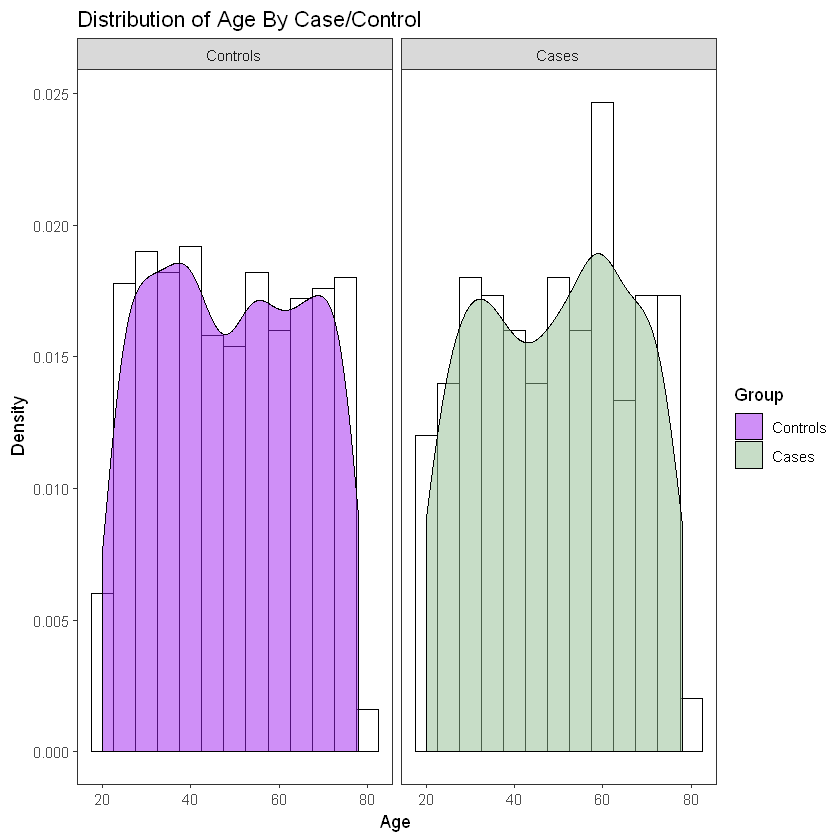

In [13]:
ggplot(merged_df, aes(x=age, fill=outcome)) + scale_fill_manual(values=c("purple", "darkseagreen"), name = "Group") +
  facet_wrap(~outcome) + 
  geom_histogram(aes(y=..density..),      
                   binwidth=5, 
                   colour="black", fill="white") +
  geom_density(alpha=.5) +   
  theme_test() + 
  xlab("Age") + ylab("Density") + ggtitle("Distribution of Age By Case/Control")

#### Box Plot

- This provides a **box plot of age** in the case and control groups.

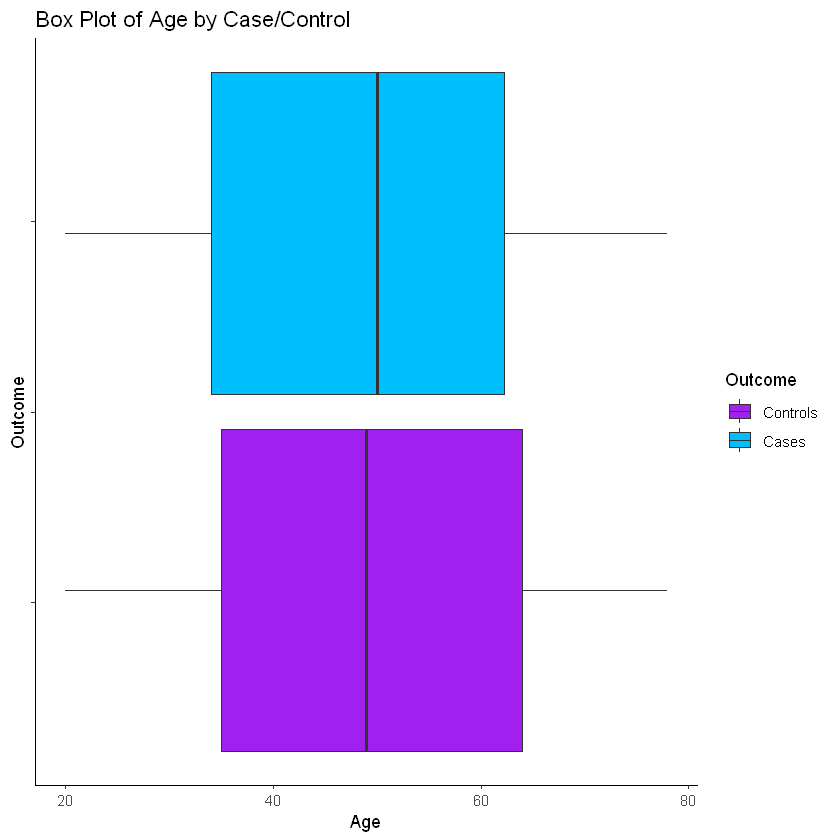

In [14]:
ggplot(merged_df, aes(y=age, fill=outcome)) + 
scale_fill_manual(values=c("purple", "deepskyblue1"), name = "Outcome") + 
geom_boxplot() + theme_classic() + coord_flip() + 
ylab("Age") + xlab("Outcome") + ggtitle("Box Plot of Age by Case/Control") + theme(axis.text.y = element_blank())

#### Bar Plot

- This provides a **bar plot of sex** in the case and control groups

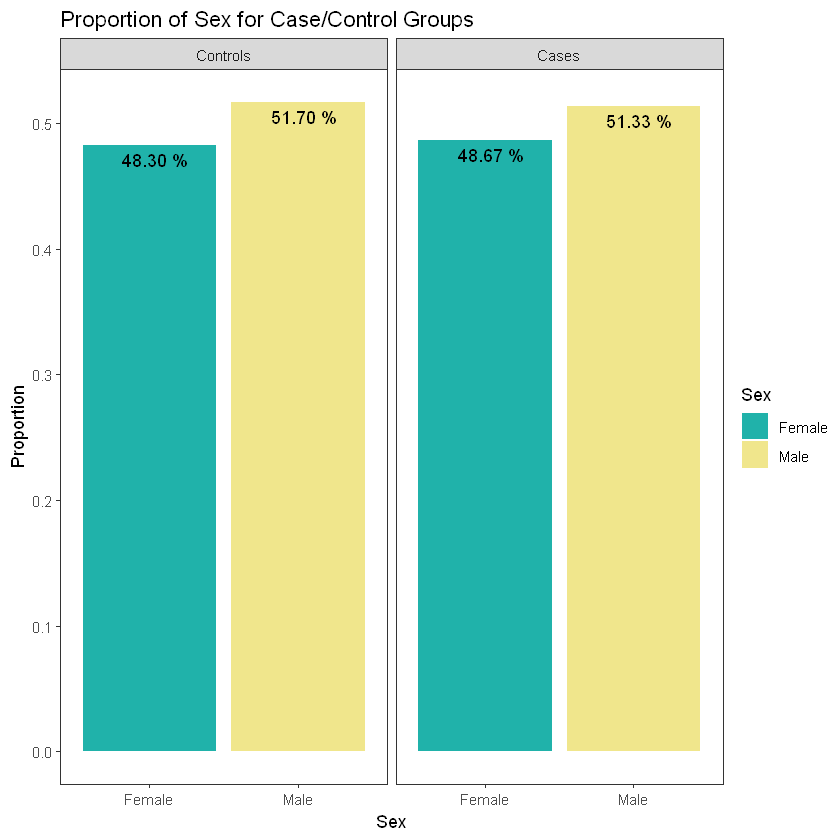

In [15]:
outcome_barplot <- merged_df %>% 
  group_by(sex_at_birth,outcome) %>% 
  summarise(n=n()) %>% 
  group_by(outcome) %>% 
  mutate(perc=100*n/sum(n))

ggplot(outcome_barplot, aes(x=sex_at_birth, y=perc/100, fill=sex_at_birth)) + scale_fill_manual(values=c("lightseagreen", "khaki"), name = "Sex") +
  geom_bar(stat="identity") +
  xlab("Sex") + ylab("Proportion") + ggtitle("Proportion of Sex for Case/Control Groups") + 
  facet_wrap(~ outcome) + geom_text(aes(label = sprintf("%.02f %%", perc), vjust = 1.5, hjust = .41))  + theme_test() 

# Statistical Analysis

- You have the option to run all the tests listed below, or simply select the specific one you need and execute its corresponding cells.

## Chi-Square

- A **2x2 contingency table** showing the counts for each condition/outcome category.
- A **Pearson's Chi-Square Test** is ran below for the condition and outcome variables using the contingency table.

In [16]:
# Replace the word 'column' with the column name you would like to test against the outcome.
chisq_table <- table(merged_df$Condition_Flag, merged_df$outcome)
chisq_table

              
               Controls Cases
  No Condition      620   130
  Condition         380   170

## T-Test

- A **variance test and t-test is ran below for age**, a quantitative variable.
- This compares the **mean age** between the case and control groups.

In [17]:
# Test for equality of variance before performing t-test.
var.test(age ~ outcome, data=merged_df, alternative = "two.sided", conf.level=0.95)


	F test to compare two variances

data:  age by outcome
F = 0.9814, num df = 999, denom df = 299, p-value = 0.8271
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.8135559 1.1730938
sample estimates:
ratio of variances 
         0.9813999 


In [18]:
# Use test above to determine if var.equal should be TRUE or FALSE.
t.test(merged_df$age ~ merged_df$outcome, var.equal = TRUE, conf.level=0.95)


	Two Sample t-test

data:  merged_df$age by merged_df$outcome
t = -0.080444, df = 1298, p-value = 0.9359
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.259436  2.081436
sample estimates:
mean in group Controls    mean in group Cases 
                49.121                 49.210 


## Logistic Regression

- Here, we run the **unadjusted and adjusted logistic regressions for the outcome and condition**.

### Unadjusted

In [19]:
# Here, we do a logistic regression without adjusting for covariates.
unadj_reg <- glm(outcome ~ Condition_Flag, family = binomial(link = "logit"), data = merged_df)
summary(unadj_reg)


Call:
glm(formula = outcome ~ Condition_Flag, family = binomial(link = "logit"), 
    data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8599  -0.8599  -0.6170  -0.6170   1.8722  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.56219    0.09646 -16.195  < 2e-16 ***
Condition_FlagCondition  0.75781    0.13349   5.677 1.37e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1404.5  on 1299  degrees of freedom
Residual deviance: 1371.9  on 1298  degrees of freedom
AIC: 1375.9

Number of Fisher Scoring iterations: 4


In [20]:
# This prints the odds ratio for the predictor variable.
as.data.frame(exp(coef(unadj_reg)))

,exp(coef(unadj_reg))
(Intercept),0.2096774
Condition_FlagCondition,2.1336032


In [21]:
# This prints the 95% confidence interval for the odds ratio.
exp(confint.default(unadj_reg))

,2.5 %,97.5 %
(Intercept),0.1735569,0.2533154
Condition_FlagCondition,1.6424350,2.7716548


### Adjusted

- This equation assumes that you imported **sex, race, and ethnicity**.
- It also assumes that you imported **date of birth to calculate age**.

In [22]:
# Here, we do a logistic regression adjusting for race, ethnicity, age, and sex at birth.
adj_reg <- glm(outcome ~ Condition_Flag + race + ethnicity + age + sex_at_birth, 
                 family = binomial(link = "logit"), data = merged_df)
summary(adj_reg)


Call:
glm(formula = outcome ~ Condition_Flag + race + ethnicity + age + 
    sex_at_birth, family = binomial(link = "logit"), data = merged_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9568  -0.7860  -0.6247  -0.5525   1.9795  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.3602383  0.2543477  -5.348 8.90e-08 ***
Condition_FlagCondition          0.7724434  0.1340259   5.763 8.24e-09 ***
raceBlack or African American   -0.1909214  0.1635159  -1.168   0.2430    
raceWhite                       -0.3570612  0.1619957  -2.204   0.0275 *  
ethnicityNot Hispanic or Latino -0.1000538  0.1339952  -0.747   0.4552    
age                              0.0005772  0.0039920   0.145   0.8850    
sex_at_birthMale                -0.0078596  0.1340036  -0.059   0.9532    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)



In [23]:
# This prints the odds ratio for all the predictor variables.
as.data.frame(exp(coef(adj_reg)))

,exp(coef(adj_reg))
(Intercept),0.2565996
Condition_FlagCondition,2.1650500
raceBlack or African American,0.8261975
raceWhite,0.6997297
ethnicityNot Hispanic or Latino,0.9047888
age,1.0005774
sex_at_birthMale,0.9921712


In [24]:
# This prints the 95% confidence interval for the odds ratio.
exp(confint.default(adj_reg))

,2.5 %,97.5 %
(Intercept),0.1558672,0.4224324
Condition_FlagCondition,1.6648874,2.8154706
raceBlack or African American,0.5996515,1.1383318
raceWhite,0.5093769,0.9612167
ethnicityNot Hispanic or Latino,0.6958094,1.1765329
age,0.9927793,1.0084368
sex_at_birthMale,0.7629965,1.2901810
